In [1]:
# coastwatch_oscar.py
# Program to download CoastWatch SST/Chlor-a original and
#  DINEOF-analyzed fields from oceanus and plot alongside
#  JPL-OSCAR surface current fields from oceanus
#
# Joseph B. Zambon
# 21 August 2018

import sys
print(sys.version)

3.5.5 |Anaconda, Inc.| (default, May 13 2018, 21:12:35) 
[GCC 7.2.0]


In [2]:
# ! conda install -y numpy
# ! conda install -y qt=5 pyqt=5
# ! conda install -y -c conda-forge pydap 
# ! conda install -y -c conda-forge cmocean
# ! conda install -y matplotlib
# ! conda install -y -c anaconda basemap
# ! conda install -y -c conda-forge basemap-data-hires=1.0.8.dev0

In [3]:
#Dependencies
import numpy as np
from pydap.client import open_url
import cmocean
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
import datetime

# For inline plotting
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Define date
yyyy=2018
mm=1
dd=8

# Define Coordinates
#coords = [43, 30, -65, -82]      #  US East Coast (N'rn FL -> S'rn NH)
coords = [38, 32, -72, -80]     # Carolinas

In [5]:
# Link OPeNDAP datasets
coastwatch_sst_url   = 'http://oceanus.meas.ncsu.edu:8080/thredds/dodsC/carolinas/coastwatch/sst.nc'
coastwatch_sst = open_url(coastwatch_sst_url)
coastwatch_chla_url  = 'http://oceanus.meas.ncsu.edu:8080/thredds/dodsC/carolinas/coastwatch/chla.nc'
coastwatch_chla = open_url(coastwatch_chla_url)
dineof_sst_url   = 'http://oceanus.meas.ncsu.edu:8080/thredds/dodsC/carolinas/coastwatch/dineof_sst.nc'
dineof_sst = open_url(dineof_sst_url)
dineof_chla_url  = 'http://oceanus.meas.ncsu.edu:8080/thredds/dodsC/carolinas/coastwatch/dineof_chla.nc'
dineof_chla = open_url(dineof_chla_url)
oscar_sfc_curr_url = 'http://oceanus.meas.ncsu.edu:8080/thredds/dodsC/global/oscar/currents.nc'
oscar_sfc_curr = open_url(oscar_sfc_curr_url)

In [6]:
# Define Subsamples
  # SST
sst_sub_inx = [np.argmin(abs(coastwatch_sst['lat'][:]-coords[1])), \
               np.argmin(abs(coastwatch_sst['lat'][:]-coords[0])), \
               np.argmin(abs(coastwatch_sst['lon'][:]-coords[3])), \
               np.argmin(abs(coastwatch_sst['lon'][:]-coords[2]))]
coastwatch_sst_otime = []
for t in range (0,size(coastwatch_sst['time'][:])):
    coastwatch_sst_otime.append(datetime.datetime.toordinal(datetime.datetime.strptime\
                                (coastwatch_sst['time'][:][t],"%Y-%m-%dT00:00:00Z")))
coastwatch_sst_otime = np.asarray(coastwatch_sst_otime)
sst_t_inx = np.argmin(abs(coastwatch_sst_otime-datetime.date.toordinal(datetime.datetime(yyyy,mm,dd))))

# Chlor-a
chla_sub_inx = [np.argmin(abs(coastwatch_chla['lat'][:]-coords[1])), \
                np.argmin(abs(coastwatch_chla['lat'][:]-coords[0])), \
                np.argmin(abs(coastwatch_chla['lon'][:]-coords[3])), \
                np.argmin(abs(coastwatch_chla['lon'][:]-coords[2]))]
coastwatch_chla_otime = []
for t in range (0,size(coastwatch_chla['time'][:])):
    coastwatch_chla_otime.append(datetime.datetime.toordinal(datetime.datetime.strptime\
                                (coastwatch_chla['time'][:][t],"%Y-%m-%dT00:00:00Z")))
coastwatch_chla_otime = np.asarray(coastwatch_chla_otime)
chla_t_inx = np.argmin(abs(coastwatch_chla_otime-datetime.date.toordinal(datetime.datetime(yyyy,mm,dd))))

# OSCAR
oscar_sub_inx = [np.argmin(abs(oscar_sfc_curr['latitude'][:]-coords[1])),  \
                 np.argmin(abs(oscar_sfc_curr['latitude'][:]-coords[0])),  \
                 np.argmin(abs(oscar_sfc_curr['longitude'][:]-360.-coords[3])), \
                 np.argmin(abs(oscar_sfc_curr['longitude'][:]-360.-coords[2]))]
oscar_date = datetime.date.toordinal(datetime.datetime(yyyy,mm,dd)) - \
             datetime.date.toordinal(datetime.datetime(1992,10,5,0,0,0))
oscar_t_inx = np.argmin(abs(oscar_sfc_curr['time'][:]-oscar_date))

# print('Returned indices...', '\n', \
#       'SST: ', sst_sub_inx, sst_t_inx, '\n', \
#       'Chlor-a: ', chla_sub_inx, chla_t_inx, '\n', \
#       'OSCAR: ', oscar_sub_inx, oscar_t_inx)

In [7]:
# Pull subsampled data                          
sst = coastwatch_sst['sst'][int(sst_t_inx),int(sst_sub_inx[0]):int(sst_sub_inx[1]),\
                            int(sst_sub_inx[2]):int(sst_sub_inx[3])]
chl_a = coastwatch_chla['chlor_a'][int(chla_t_inx),int(chla_sub_inx[0]):int(chla_sub_inx[1]),\
                            int(chla_sub_inx[2]):int(chla_sub_inx[3])]
df_sst = dineof_sst['sst'][int(sst_t_inx),int(sst_sub_inx[0]):int(sst_sub_inx[1]),\
                            int(sst_sub_inx[2]):int(sst_sub_inx[3])]
df_chl_a = dineof_chla['chlor_a'][int(chla_t_inx),int(chla_sub_inx[0]):int(chla_sub_inx[1]),\
                            int(chla_sub_inx[2]):int(chla_sub_inx[3])]
oscar_u = oscar_sfc_curr['u'][int(oscar_t_inx),0,int(oscar_sub_inx[1]):int(oscar_sub_inx[0]),\
                              int(oscar_sub_inx[2]):int(oscar_sub_inx[3])]
oscar_v = oscar_sfc_curr['v'][int(oscar_t_inx),0,int(oscar_sub_inx[1]):int(oscar_sub_inx[0]),\
                              int(oscar_sub_inx[2]):int(oscar_sub_inx[3])]

/home/jbzambon/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3122: RuntimeWarning: invalid value encountered in greater_equal
  farnorth = np.abs(lats+dlat) >= 90.0
/home/jbzambon/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


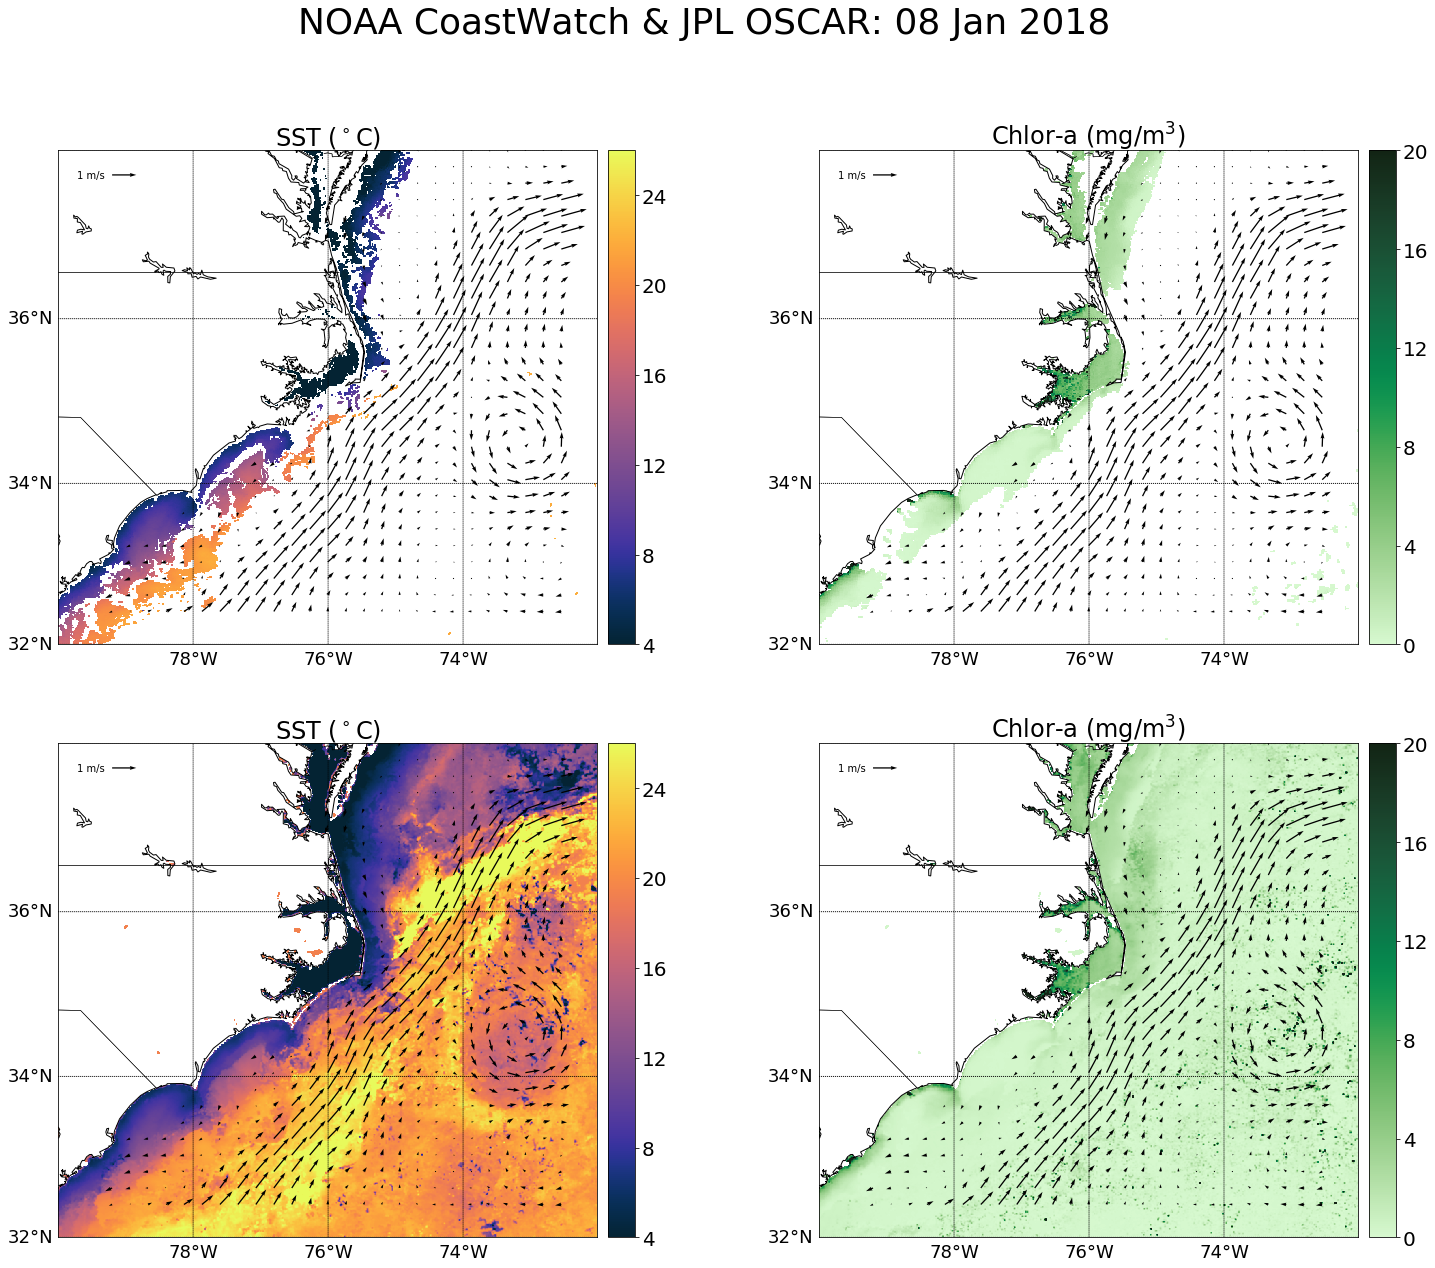

In [8]:
fig, ax = plt.subplots(2,2,figsize=(25,20))

parallels = np.arange(-90,90,2.)
meridians = np.arange(-180,180,2.)
sst_range = [4,26,4]   #min, max, colorbar step
chla_range = [0,20,4] #min, max, colorbar step

plt.clf()
plt.suptitle('NOAA CoastWatch & JPL OSCAR: ' + datetime.datetime(yyyy,mm,dd).strftime("%d %b %Y"),fontsize=36,family='Helvetica')

plt.subplot(2,2,1)
map = Basemap(projection='merc',
      resolution='i',lat_0=((np.max(sst.lat)-np.min(sst.lat))/2),
      lon_0=((np.max(sst.lon)-np.min(sst.lon))/2),
      llcrnrlon=np.min(sst.lon),llcrnrlat=np.min(sst.lat),
      urcrnrlon=np.max(sst.lon),urcrnrlat=np.max(sst.lat))
map.drawcoastlines()
map.drawcountries()
map.drawstates()
[X,Y] = np.meshgrid(sst.lon,sst.lat)
data = np.squeeze(sst.sst)
data[data<-5]=np.nan; data= np.ma.array(data,mask=np.isnan(data))
map.pcolormesh(X,Y,data,cmap=cmocean.cm.thermal,vmin=sst_range[0],vmax=sst_range[1],latlon='true')
# Fix OSCAR data for map
oscar_map_lat = np.asarray(oscar_u.latitude)
oscar_map_lon = np.asarray(oscar_u.longitude)-360.
oscar_map_u = np.squeeze(np.asarray(oscar_u.u))
oscar_map_v = np.squeeze(np.asarray(oscar_v.v))
uproj,vproj,xx,yy = map.transform_vector(np.flipud(oscar_map_u),np.flipud(oscar_map_v),oscar_map_lon,np.flipud(oscar_map_lat),31,31,returnxy=True,masked=True)
Q=map.quiver(xx,yy,uproj,vproj)
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=18)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=18)
plt.title(('SST ($^\circ$C)'),fontsize=24,family='Helvetica')
cbar=map.colorbar(location='right',ticks=np.arange(sst_range[0],sst_range[1]+1e-5,sst_range[2]))
cbar.ax.tick_params(labelsize=20)
qk=plt.quiverkey(Q, 0.1, 0.95, 1, '1 m/s', labelpos='W')

plt.subplot(2,2,2)
map = Basemap(projection='merc',
      resolution='i',lat_0=((np.max(chl_a.lat)-np.min(chl_a.lat))/2),
      lon_0=((np.max(chl_a.lon)-np.min(chl_a.lon))/2),
      llcrnrlon=np.min(chl_a.lon),llcrnrlat=np.min(chl_a.lat),
      urcrnrlon=np.max(chl_a.lon),urcrnrlat=np.max(chl_a.lat))
map.drawcoastlines()
map.drawcountries()
map.drawstates()
[X,Y] = np.meshgrid(chl_a.lon,chl_a.lat)
data = np.squeeze(chl_a.chlor_a)
data[data<-5]=np.nan; data= np.ma.array(data,mask=np.isnan(data))
map.pcolormesh(X,Y,data,cmap=cmocean.cm.algae,vmin=chla_range[0],vmax=chla_range[1],latlon='true')
# Fix OSCAR data for map
oscar_map_lat = np.asarray(oscar_u.latitude)
oscar_map_lon = np.asarray(oscar_u.longitude)-360.
oscar_map_u = np.squeeze(np.asarray(oscar_u.u))
oscar_map_v = np.squeeze(np.asarray(oscar_v.v))
uproj,vproj,xx,yy = map.transform_vector(np.flipud(oscar_map_u),np.flipud(oscar_map_v),oscar_map_lon,np.flipud(oscar_map_lat),31,31,returnxy=True,masked=True)
Q=map.quiver(xx,yy,uproj,vproj)
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=18)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=18)
plt.title(('Chlor-a (mg/m$^3$)'),fontsize=24,family='Helvetica')
cbar=map.colorbar(location='right',ticks=np.arange(chla_range[0],chla_range[1]+1e-5,chla_range[2]))
cbar.ax.tick_params(labelsize=20)
qk=plt.quiverkey(Q, 0.1, 0.95, 1, '1 m/s', labelpos='W')

plt.subplot(2,2,3)
map = Basemap(projection='merc',
      resolution='i',lat_0=((np.max(sst.lat)-np.min(sst.lat))/2),
      lon_0=((np.max(sst.lon)-np.min(sst.lon))/2),
      llcrnrlon=np.min(sst.lon),llcrnrlat=np.min(sst.lat),
      urcrnrlon=np.max(sst.lon),urcrnrlat=np.max(sst.lat))
map.drawcoastlines()
map.drawcountries()
map.drawstates()
[X,Y] = np.meshgrid(sst.lon,sst.lat)
data = np.squeeze(df_sst.sst)
data[data<-5]=np.nan; data= np.ma.array(data,mask=np.isnan(data))
map.pcolormesh(X,Y,data,cmap=cmocean.cm.thermal,vmin=sst_range[0],vmax=sst_range[1],latlon='true')
# Fix OSCAR data for map
oscar_map_lat = np.asarray(oscar_u.latitude)
oscar_map_lon = np.asarray(oscar_u.longitude)-360.
oscar_map_u = np.squeeze(np.asarray(oscar_u.u))
oscar_map_v = np.squeeze(np.asarray(oscar_v.v))
uproj,vproj,xx,yy = map.transform_vector(np.flipud(oscar_map_u),np.flipud(oscar_map_v),oscar_map_lon,np.flipud(oscar_map_lat),31,31,returnxy=True,masked=True)
Q=map.quiver(xx,yy,uproj,vproj)
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=18)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=18)
plt.title(('SST ($^\circ$C)'),fontsize=24,family='Helvetica')
cbar=map.colorbar(location='right',ticks=np.arange(sst_range[0],sst_range[1]+1e-5,sst_range[2]))
cbar.ax.tick_params(labelsize=20)
qk=plt.quiverkey(Q, 0.1, 0.95, 1, '1 m/s', labelpos='W')

plt.subplot(2,2,4)
map = Basemap(projection='merc',
      resolution='i',lat_0=((np.max(chl_a.lat)-np.min(chl_a.lat))/2),
      lon_0=((np.max(chl_a.lon)-np.min(chl_a.lon))/2),
      llcrnrlon=np.min(chl_a.lon),llcrnrlat=np.min(chl_a.lat),
      urcrnrlon=np.max(chl_a.lon),urcrnrlat=np.max(chl_a.lat))
map.drawcoastlines()
map.drawcountries()
map.drawstates()
[X,Y] = np.meshgrid(chl_a.lon,chl_a.lat)
data = np.squeeze(df_chl_a.chlor_a)
data[data<-5]=np.nan; data= np.ma.array(data,mask=np.isnan(data))
map.pcolormesh(X,Y,data,cmap=cmocean.cm.algae,vmin=chla_range[0],vmax=chla_range[1],latlon='true')
# Fix OSCAR data for map
oscar_map_lat = np.asarray(oscar_u.latitude)
oscar_map_lon = np.asarray(oscar_u.longitude)-360.
oscar_map_u = np.squeeze(np.asarray(oscar_u.u))
oscar_map_v = np.squeeze(np.asarray(oscar_v.v))
uproj,vproj,xx,yy = map.transform_vector(np.flipud(oscar_map_u),np.flipud(oscar_map_v),oscar_map_lon,np.flipud(oscar_map_lat),31,31,returnxy=True,masked=True)
Q=map.quiver(xx,yy,uproj,vproj)
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=18)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=18)
plt.title(('Chlor-a (mg/m$^3$)'),fontsize=24,family='Helvetica')
cbar=map.colorbar(location='right',ticks=np.arange(chla_range[0],chla_range[1]+1e-5,chla_range[2]))
cbar.ax.tick_params(labelsize=20)
qk=plt.quiverkey(Q, 0.1, 0.95, 1, '1 m/s', labelpos='W')

fig.savefig('coastwatch_' + datetime.datetime(yyyy,mm,dd).strftime("%d%b%Y"),dpi=50)

[[ 0.84290226  0.97691284  0.81464957  1.        ]
 [ 0.83798987  0.97324073  0.80884306  1.        ]
 [ 0.8330792   0.96958222  0.80305326  1.        ]
 ..., 
 [ 0.07158041  0.14886551  0.08459735  1.        ]
 [ 0.07022733  0.145481    0.08182252  1.        ]
 [ 0.06885643  0.14208946  0.07903363  1.        ]]
